In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from hypopt import GridSearch
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Importe as bibliotecas de Pipelines e Pré-processadores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from plot_metric.functions import BinaryClassification


### Hilfsfunktionfunktionen:

In [2]:
def acuracia(clf,X,y):
    resultado = cross_val_predict(best_lr_clf,X,y,cv=10)
    return accuracy_score(y,resultado)

In [3]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);

In [4]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);

In [5]:
random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

In [6]:
df = pd.read_parquet('analize.parquet')

In [7]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,France,Spain,Germany
0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,1.0,0.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,1.0,0.0,0.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,1.0,0.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,1.0,0.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,1.0,0.0,0.0,1.0,0.0


### Klassenungleichgewichten


- Es Gibt ein Ungleichgewicht in den vorherzusagenden Klassen, wobei eine Klasse (0 – Churn Rate) viel häufiger vorkommt als die andere (1 – Churn Rate):
- Das könnte die Ergbnisse der Modelle beinflussen


In [8]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

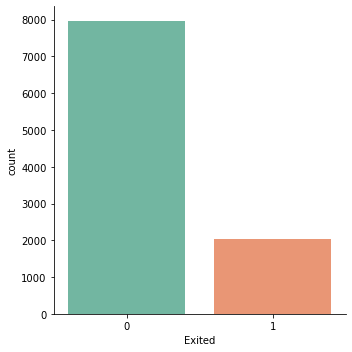

In [9]:
%matplotlib inline
sns.catplot(x="Exited", kind="count", palette="Set2", data= df )

In [10]:
y = df['Exited']
X = df.drop(columns=['Exited'])

### UnderSampling

- Ungleichgewicht zu kompensieren, es wird die Methode UnderSampling implemetiert.
- So werden die beiden Klassen gleichgewichtet.

In [11]:
nr = NearMiss()
X, y = nr.fit_resample(X, y)

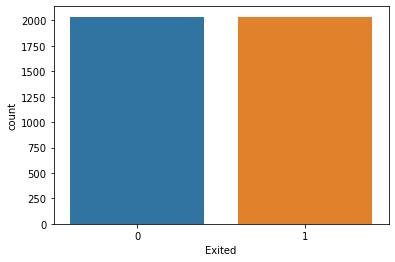

In [12]:
ax = sns.countplot(x=y)

In [13]:
###Splitvon den Datensatz training und Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) 

### 1.1 Logistic regression
- Die Modelle wurden durch die Bewertung der verschiedenen Metriken und den Einsatz von UnderSampling-Techniken untersucht.
- Für das Modell wurde Optimieriert mit ein Pipeline, sowie wurden verschiedene Parameter in den Modell gestest
- Die beste Modell wurde erreicht ohne die Cross validation
- Es gibt schwierigkeiten mit dem Modell die Klase 1 zu bewerten 
- Es gibt zu viele Negative False 

### Final Model:
- Undersampling
- BestHyperparametros:'classify__C': 0.1 ,  reduce_dim__n_components': 5
- Recall Classe 1 = 84%,  accuracy = 89%
- roc curve  87

In [113]:
# Pipeline
pipe = Pipeline([
        ('z-score', StandardScaler()),
        ('reduce_dim', PCA(n_components=4)),
        ('classify', LogisticRegression(C=5))])

In [15]:
# Parameterwertkombinationen für die Funktion 
param_grid = {
    'reduce_dim__n_components': [5,6,7,8,9],
    'classify__C': [0.1,0.2,0.3,0.4,0.5],
    
}

In [16]:
# Suche nach spezifizierten Parameterwerten
best_lr_clf = GridSearch(pipe, param_grid=param_grid,cv_folds=10)

In [17]:
best_lr_clf.fit(X_train, y_train)

Pipeline(steps=[('z-score', StandardScaler()),
                ('reduce_dim', PCA(n_components=5)),
                ('classify', LogisticRegression(C=0.1))])

In [18]:
best_lr_clf.best_estimator_

Pipeline(steps=[('z-score', StandardScaler()),
                ('reduce_dim', PCA(n_components=5)),
                ('classify', LogisticRegression(C=0.1))])

In [19]:
y_test_pred = best_lr_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

In [20]:
print("Classification Report:\n",classification_report(y_test,y_test_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("")
print("Test Data Score:\n",best_lr_clf.score(X_test,y_test)*100)
print("")
print (pd.crosstab(y_test, y_test_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       611
           1       0.93      0.84      0.89       612

    accuracy                           0.89      1223
   macro avg       0.90      0.89      0.89      1223
weighted avg       0.90      0.89      0.89      1223

Confusion Matrix:
 [[575  36]
 [ 96 516]]

Test Data Score:
 89.20686835650041

Predito    0    1   All
Real                   
0        575   36   611
1         96  516   612
All      671  552  1223


### Cross Valitation
- Validierung von Modellen

In [21]:
resultado = cross_val_predict(best_lr_clf,X,y,cv=10)
print(classification_report(y,resultado))
print (pd.crosstab(y,resultado, rownames=['Real'], colnames=['Predito'], margins=True))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2037
           1       0.92      0.82      0.86      2037

    accuracy                           0.87      4074
   macro avg       0.88      0.87      0.87      4074
weighted avg       0.88      0.87      0.87      4074

Predito     0     1   All
Real                     
0        1886   151  2037
1         376  1661  2037
All      2262  1812  4074


In [22]:
from plot_metric.functions import BinaryClassification

In [23]:
bc1 = BinaryClassification(y,resultado, labels=["Ohne  Interesse", "Mit Interesse"])

(array([0.        , 0.07412862, 1.        ]),
 array([0.        , 0.81541483, 1.        ]),
 array([2, 1, 0], dtype=int64),
 0.8706431026018655)

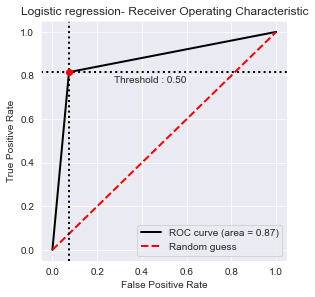

In [24]:
ax = plt.figure(figsize=(15,15))
ax.add_subplot(3,3,1)
bc1.plot_roc_curve( title='Logistic regression- Receiver Operating Characteristic')

## 1.2 SVM 
- Die Modelle wurden durch die Bewertung der verschiedenen Metriken und den Einsatz von UnderSampling-Techniken untersucht. 

### Ergbnisse
-  Hyperparametros: Wert list_C = [0.001, 0.01, 0.1, 1, 10, 100]
-  Hyperparametros: lista_gamma = [0.001, 0.01, 0.1, 1, 10, 100]
-  kernel 'rbf'
-  Metrik: Recall Classe 1 = 87%, Acurácia = 91%0
-  roc curve 0.92
-  Die klasse 1 hat eine hohe Zahl von Falsch-Positiv 

In [25]:
# Importe as bibliotecas de Pipelines e Pré-processadores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [26]:
# Pipelines

pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', SVC())
])


pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', SVC( kernel='rbf',probability=True))
])

pip_3 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True))
])

pip_4 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', SVC(kernel='poly'))
])

pip_5 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', SVC(kernel='linear'))
])

###  Kernel in Test
- Best PIpeline_3
- Kernel rbf
- StandardScaler
- SVC(C=100, gamma=0.01)

In [27]:
acuracia(pip_1,X,y)

0.8706431026018655

In [28]:
acuracia(pip_2,X,y)

0.8706431026018655

In [29]:
# best Ergbnisse
acuracia(pip_3,X,y)

0.8706431026018655

In [30]:
acuracia(pip_4,X,y)

0.8706431026018655

In [31]:
acuracia(pip_5,X,y)

0.8706431026018655

## Tunning
- Test mit verschieden Parameter
- Wert C:   [0.001, 0.01, 0.1, 1, 10, 100]
- Wert Gamma:   [0.001, 0.01, 0.1, 1, 10, 100]

In [32]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

In [33]:
# Wert C
lista_C = [0.001, 0.01, 0.1, 1, 10, 100]

# Wert Gamma
lista_gamma = [0.001, 0.01, 0.1, 1, 10, 100]

In [34]:
# Dict für die Parameter.
parametros_grid = dict(clf__C=lista_C, clf__gamma=lista_gamma)

In [35]:
parametros_grid

{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [36]:
# Objekt Grid bekommt die pipeline 3 und config
best_svc_clf = GridSearchCV(pip_3, parametros_grid, cv=10, scoring='accuracy')

In [37]:
# appl gridsearch mit Klassen und train.
best_svc_clf .fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC(probability=True))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

##  Best Ergbnisse Grid

In [38]:
# print von Ergbnisse und Kombination
best_svc_clf.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=100, gamma=0.01, probability=True))])

In [39]:
best_svc_clf.best_params_

{'clf__C': 100, 'clf__gamma': 0.01}

In [40]:
best_svc_clf.best_estimator_


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=100, gamma=0.01, probability=True))])

In [41]:
print(pd.crosstab(y,resultado, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1   All
Real                     
0        1886   151  2037
1         376  1661  2037
All      2262  1812  4074


In [42]:
## Metrik
resultado_2 = cross_val_predict(pip_3,X,y,cv=10)
print(classification_report(y,resultado))
print (pd.crosstab(y,resultado, rownames=['Real'], colnames=['Predito'], margins=True))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2037
           1       0.92      0.82      0.86      2037

    accuracy                           0.87      4074
   macro avg       0.88      0.87      0.87      4074
weighted avg       0.88      0.87      0.87      4074

Predito     0     1   All
Real                     
0        1886   151  2037
1         376  1661  2037
All      2262  1812  4074


In [43]:
bc2 = BinaryClassification(y,resultado_2, labels=["Ohne  Interesse", "Mit Interesse"])

(array([0.        , 0.03976436, 1.        ]),
 array([0.        , 0.87334315, 1.        ]),
 array([2, 1, 0], dtype=int64),
 0.9167893961708395)

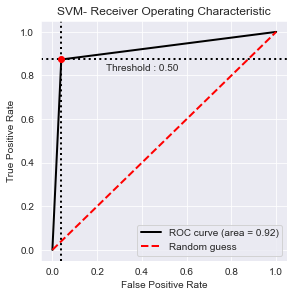

In [44]:
ax = plt.figure(figsize=(15,15))
ax.add_subplot(3,3,1)
bc2.plot_roc_curve( title='SVM- Receiver Operating Characteristic')

## 1.3 K-Nearest Neighbors

- UnderSampling
 
- Hyperparametros: PCA = 7, Nachbar = 3

- Recall Classe 1 = 84%, accuracy = 89%

- roc curve 84%



In [45]:
nr = NearMiss()
X, y = nr.fit_resample(X, y)

In [46]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) 

In [47]:
### Pipeline 
pipe = Pipeline([
        ('z-score', StandardScaler()),
        ('reduce_dim', PCA(n_components=7)),
        ('classify', KNeighborsClassifier(n_neighbors=5))])

In [48]:
##  hyperparameter
param_grid = {
    'reduce_dim__n_components': [1,2,3,4,5,6,7,8,9],
    'classify__n_neighbors': [2,3]
}

In [49]:
##  Grid do Hyplopt
best_knn_clf = GridSearch(pipe, param_grid=param_grid,cv_folds=10)

In [50]:
## hyperparametros crossvalitation
best_knn_clf.fit(X_train, y_train)

Pipeline(steps=[('z-score', StandardScaler()),
                ('reduce_dim', PCA(n_components=3)),
                ('classify', KNeighborsClassifier(n_neighbors=3))])

In [51]:
#best classificador 
best_knn_clf.best_estimator_

Pipeline(steps=[('z-score', StandardScaler()),
                ('reduce_dim', PCA(n_components=3)),
                ('classify', KNeighborsClassifier(n_neighbors=3))])

In [52]:
best_knn_clf.best_params

{'classify__n_neighbors': 3, 'reduce_dim__n_components': 3}

In [53]:
best_knn_clf.get_best_score()

0.88845663108821

In [54]:
y_test_pred = best_knn_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

In [55]:
print("Classification Report:\n",classification_report(y_test,y_test_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("")
print("Test Data Score:\n",best_knn_clf.score(X_test,y_test)*100)
print("")
print (pd.crosstab(y_test, y_test_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       611
           1       0.92      0.87      0.90       612

    accuracy                           0.90      1223
   macro avg       0.90      0.90      0.90      1223
weighted avg       0.90      0.90      0.90      1223

Confusion Matrix:
 [[565  46]
 [ 77 535]]

Test Data Score:
 89.94276369582992

Predito    0    1   All
Real                   
0        565   46   611
1         77  535   612
All      642  581  1223


###  Cross Valitation

In [56]:
knn = KNeighborsClassifier(n_neighbors=3)

In [57]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [58]:
resultado = knn.predict(X_test)

In [59]:
from sklearn import metrics
print(metrics.classification_report(y_test,resultado))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       611
           1       0.92      0.74      0.82       612

    accuracy                           0.84      1223
   macro avg       0.85      0.84      0.84      1223
weighted avg       0.85      0.84      0.84      1223



In [60]:
print (pd.crosstab(y_test,resultado, rownames=['Real'], colnames=['          Predito'], margins=True))

          Predito    0    1   All
Real                             
0                  569   42   611
1                  157  455   612
All                726  497  1223


In [61]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, df.drop('Exited',axis=1),df['Exited'], cv=5)
scores

array([0.7315, 0.74  , 0.7295, 0.74  , 0.7365])

## CridSearch
- Es wird versucht mit verschieden Parameter ein besser Ergbnisse zu erzeugen
- Best Wert k = {'n_neighbors': 24} mit 0.7964  accuracy

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
# Parameter List
k_list = list(range(1,31))

In [64]:
k_values = dict(n_neighbors=k_list)
k_values

{'n_neighbors': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30]}

In [65]:
knn_clf = GridSearchCV(knn, k_values, cv=5, scoring='accuracy')

In [66]:
# Trainning 
knn_clf.fit(df.drop('Exited',axis=1),df['Exited'])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [67]:
knn_clf.cv_results_

{'mean_fit_time': array([0.01440301, 0.01420083, 0.01399684, 0.01379952, 0.01319818,
        0.01399822, 0.01379986, 0.01400261, 0.01379972, 0.01380019,
        0.01379895, 0.01359267, 0.01400018, 0.01359768, 0.01399908,
        0.01399975, 0.01359558, 0.01379848, 0.01360016, 0.01339998,
        0.01339874, 0.01400003, 0.01359506, 0.01359386, 0.01379986,
        0.01360102, 0.01400166, 0.01360092, 0.01360035, 0.01419888]),
 'std_fit_time': array([7.98914861e-04, 3.99404980e-04, 5.94231704e-06, 4.00471783e-04,
        4.00045187e-04, 6.33469890e-04, 4.00042886e-04, 7.62104531e-06,
        3.99853572e-04, 4.01402284e-04, 4.00073707e-04, 4.87257011e-04,
        6.57274664e-07, 4.87723055e-04, 6.32185061e-04, 2.43793927e-06,
        4.85799464e-04, 3.99139305e-04, 4.90214536e-04, 4.90057906e-04,
        4.90489002e-04, 6.32485345e-04, 4.87750420e-04, 4.97025864e-04,
        3.99567841e-04, 4.90817972e-04, 3.59814634e-06, 4.90546017e-04,
        4.89397631e-04, 3.98588680e-04]),
 'mean_scor

In [68]:
print("Best Wert k = {} mit {}  accuracy".format(knn_clf.best_params_,knn_clf.best_score_))

Best Wert k = {'n_neighbors': 24} mit 0.7964  accuracy


In [69]:
acuracia(best_knn_clf,X_test,y_test)

0.8953393295175798

In [70]:
resultado = cross_val_predict(best_knn_clf,X,y,cv=10)
print(classification_report(y,resultado))
print (pd.crosstab(y,resultado, rownames=['Real'], colnames=['Predito'], margins=True))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2037
           1       0.91      0.80      0.85      2037

    accuracy                           0.86      4074
   macro avg       0.87      0.86      0.86      4074
weighted avg       0.87      0.86      0.86      4074

Predito     0     1   All
Real                     
0        1878   159  2037
1         410  1627  2037
All      2288  1786  4074


### Best Score
- k=24

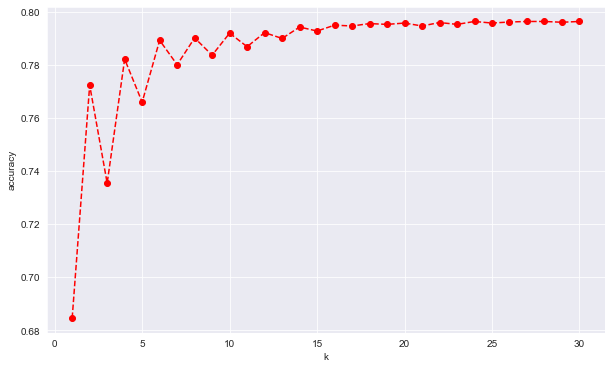

In [71]:
scores=[]
results = knn_clf.cv_results_
for mean in results['mean_test_score']:
    scores.append(mean)


plt.figure(figsize=(10,6))
plt.plot(k_list,scores,color='red',linestyle='dashed',marker='o')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

In [72]:
bc3 = BinaryClassification(y,resultado, labels=["Ohne  Interesse", "Mit Interesse"])

(array([0.        , 0.07805596, 1.        ]),
 array([0.        , 0.79872361, 1.        ]),
 array([2, 1, 0], dtype=int64),
 0.8603338242513501)

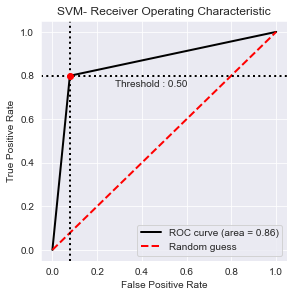

In [73]:
ax = plt.figure(figsize=(15,15))
ax.add_subplot(3,3,1)
bc3.plot_roc_curve( title='SVM- Receiver Operating Characteristic')

## 1.4 Decision Tree 


- Undersampling
- Recall Classe 1 = 91%, accuracy = 89%
- roc curve 84

In [74]:
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris
from sklearn import tree
import numpy as np
import pandas as pd

In [75]:
clf = tree.DecisionTreeClassifier(random_state=2, max_depth=5,criterion='entropy',max_features=None,)

#### Parâmetros do  classificador DecisionTreeClassifier
* criterion:Die Funktion zur Messung der Qualität eines SPLIt
* splitter:Die Strategie, die verwendet wird, um die Aufteilung an jedem Knoten auszuwählen.
* max_depth: um die Größe des Baums zu steuern
* min_samples_split:  um sicherzustellen, dass mehrere Stichproben jede Entscheidung im Baum beeinflussen, indem Sie steuern, welche Aufteilungen berücksichtigt werden
* min_samples_leaf:  Minimal NR von den Blätter
* Wichtig Features, NumOfProducts, HasCrCard Tenure  
        



In [76]:
best_tree_clf = clf.fit(X_test,y_test)

In [77]:
best_tree_clf 

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2)

In [78]:
best_tree_clf .feature_importances_

array([0.00691929, 0.08705302, 0.        , 0.68327122, 0.18577142,
       0.        , 0.01803067, 0.01532977, 0.00362461, 0.        ,
       0.        , 0.        , 0.        ])

In [79]:
best_tree_clf 

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2)

In [80]:
## Lista de features
L = df.columns.tolist()
features_names = L[1:14]
class_names = L[14:]
feature_imp = pd.Series(best_tree_clf.feature_importances_,index=features_names).sort_values(ascending=False)
feature_imp

NumOfProducts      0.683271
HasCrCard          0.185771
Tenure             0.087053
EstimatedSalary    0.018031
Exited             0.015330
Age                0.006919
Female             0.003625
Balance            0.000000
IsActiveMember     0.000000
Male               0.000000
France             0.000000
Spain              0.000000
Germany            0.000000
dtype: float64

In [81]:
def visualiza_features_importantes(features_lista):
    %matplotlib inline

    plt.figure(figsize=(16,8))
    sns.barplot(x=features_lista, y=features_lista.index)

    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

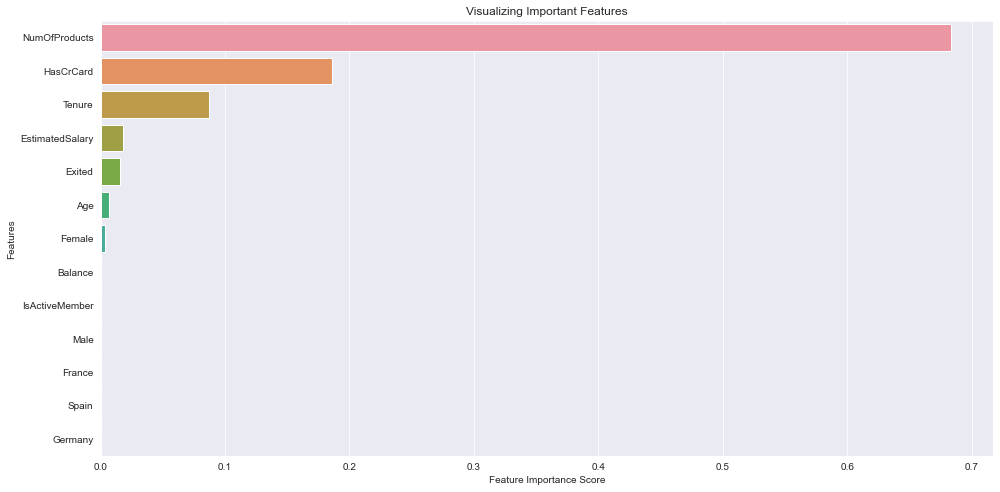

In [82]:
visualiza_features_importantes(feature_imp)

In [83]:
acuracia(best_tree_clf ,X_test,y_test)

0.8953393295175798

In [84]:
resultado = cross_val_predict(best_tree_clf,X_test,y_test,cv=10)
print(classification_report(y_test,resultado))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       611
           1       0.96      0.87      0.91       612

    accuracy                           0.91      1223
   macro avg       0.92      0.91      0.91      1223
weighted avg       0.92      0.91      0.91      1223



In [85]:
print("Classification Report:\n",classification_report(y_test,y_test_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("")
print("Test Data Score:\n",best_tree_clf .score(X_test,y_test)*100)
print("")
print (pd.crosstab(y_test, y_test_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       611
           1       0.92      0.87      0.90       612

    accuracy                           0.90      1223
   macro avg       0.90      0.90      0.90      1223
weighted avg       0.90      0.90      0.90      1223

Confusion Matrix:
 [[565  46]
 [ 77 535]]

Test Data Score:
 92.96811120196239

Predito    0    1   All
Real                   
0        565   46   611
1         77  535   612
All      642  581  1223


In [86]:
pipe = Pipeline([
        ('z-score', StandardScaler()),
        ('reduce_dim', PCA(n_components=8)),
        ('classify', tree.DecisionTreeClassifier(criterion='entropy', max_depth = 5,random_state=10))])

In [87]:
clf = pipe.fit(X_train, y_train)

In [88]:
y_test_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

In [89]:
print("Classification Report:\n",classification_report(y_test,y_test_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("")
print("Test Data Score:\n",clf.score(X_test,y_test)*100)
print("")
print(pd.crosstab(y_test, y_test_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       611
           1       0.92      0.83      0.87       612

    accuracy                           0.88      1223
   macro avg       0.88      0.88      0.88      1223
weighted avg       0.88      0.88      0.88      1223

Confusion Matrix:
 [[567  44]
 [106 506]]

Test Data Score:
 87.73507767784137

Predito    0    1   All
Real                   
0        567   44   611
1        106  506   612
All      673  550  1223


## Tuning CridSearch

In [90]:
param_grid = {
    'reduce_dim__n_components': [1,2,3,4,5],
    'classify__max_depth': [5,10,15],
    'classify__criterion': ['gini','entropy']
}

In [91]:
## Criação da Grid do Hyplopt
tree_clf = GridSearch(pipe, param_grid=param_grid,cv_folds=5)

In [92]:
## Procura os hyperparametros utilizando os dados de treino com validação cruzada
tree_clf.fit(X_train, y_train)

Pipeline(steps=[('z-score', StandardScaler()),
                ('reduce_dim', PCA(n_components=3)),
                ('classify',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=10))])

In [93]:
print(tree_clf.best_params)

{'classify__criterion': 'entropy', 'classify__max_depth': 10, 'reduce_dim__n_components': 3}


In [94]:
tree_clf.best_estimator_

Pipeline(steps=[('z-score', StandardScaler()),
                ('reduce_dim', PCA(n_components=3)),
                ('classify',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=10))])

In [95]:
y_test_pred = tree_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

In [96]:
print("Classification Report:\n",classification_report(y_test,y_test_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("")
print("Test Data Score:\n",tree_clf.score(X_test,y_test)*100)
print("")
print(pd.crosstab(y_test, y_test_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89       611
           1       0.91      0.86      0.88       612

    accuracy                           0.88      1223
   macro avg       0.89      0.88      0.88      1223
weighted avg       0.89      0.88      0.88      1223

Confusion Matrix:
 [[557  54]
 [ 87 525]]

Test Data Score:
 88.47097301717089

Predito    0    1   All
Real                   
0        557   54   611
1         87  525   612
All      644  579  1223


(array([0.        , 0.04091653, 1.        ]),
 array([0.        , 0.86764706, 1.        ]),
 array([2, 1, 0], dtype=int64),
 0.9133652642726486)

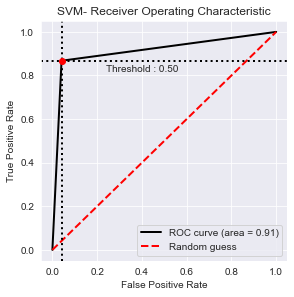

In [97]:
bc4 = BinaryClassification(y_test,resultado, labels=["Ohne  Interesse", "Mit Interesse"])
ax = plt.figure(figsize=(15,15))
ax.add_subplot(3,3,1)
bc4.plot_roc_curve( title='SVM- Receiver Operating Characteristic')

## 1.5 XGBoost

- Undersampling
- 'learning_rate': [0.001, 0.01],
- 'max_depth': [3, 4],  # default=6
- 'reg_alpha': [1, 2],
- 'reg_lambda': [1, 2],
- 'subsample': [0.5, 0.75],
- 'colsample_bytree': [0.50, 0.75],
- 'gamma': [0.1, 0.5, 1],
- 'min_child_weight': [1]



- Final Modell
-  PCA = 2, max_depth = 5
-  Recall Classe 1 = 86% Acuracia = 88%

In [98]:
### Split dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [99]:
xgb_clf = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb_clf,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)

best_xgb_clf.best_score_

0.895438596491228

In [100]:
print("Classification Report:\n",classification_report(y_test,y_test_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("")
print("Test Data Score:\n",best_xgb_clf.score(X_test,y_test)*100)
print("")
print(pd.crosstab(y_test, y_test_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89       611
           1       0.91      0.86      0.88       612

    accuracy                           0.88      1223
   macro avg       0.89      0.88      0.88      1223
weighted avg       0.89      0.88      0.88      1223

Confusion Matrix:
 [[557  54]
 [ 87 525]]

Test Data Score:
 89.37908496732027

Predito    0    1   All
Real                   
0        557   54   611
1         87  525   612
All      644  579  1223


(array([0.        , 0.04091653, 1.        ]),
 array([0.        , 0.86764706, 1.        ]),
 array([2, 1, 0], dtype=int64),
 0.9133652642726486)

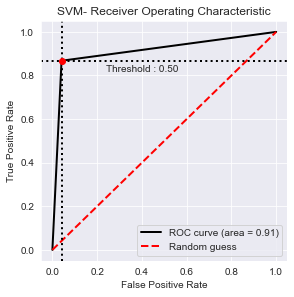

In [101]:
bc5 = BinaryClassification(y_test,resultado, labels=["Ohne  Interesse", "Mit Interesse"])
ax = plt.figure(figsize=(15,15))
ax.add_subplot(3,3,1)
bc5.plot_roc_curve( title='SVM- Receiver Operating Characteristic')

## 5.3  Ensemble
Wir können die Vorhersagen all dieser Klassifikatoren kombinieren, um festzustellen, ob wir im Vergleich zu jedem einzelnen Klassifikator eine bessere Vorhersageleistung erhalten. Diese Praxis ist die Hauptmotivation hinter Ensemble Learning.


Soft Voting
-----------------
  Recall:  0.865


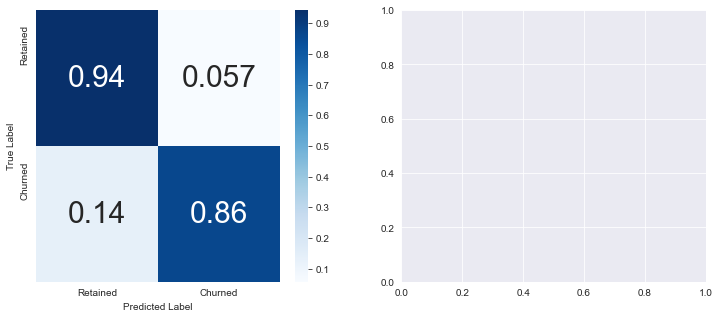

In [102]:
estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('tree', tree_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('knn',best_knn_clf.best_estimator_)
             ]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)

tuned_voting_soft = tuned_voting_soft.fit(X, y)
tuned_voting_soft.predict(X)

estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')


print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
#plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)
#Soft Voting


In [103]:
print("Classification Report:\n",classification_report(y_test,y_test_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_test_pred))
print("")
print("Test Data Score:\n",tuned_voting_soft.score(X_test,y_test)*100)
print("")
print(pd.crosstab(y_test, y_test_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89       611
           1       0.91      0.86      0.88       612

    accuracy                           0.88      1223
   macro avg       0.89      0.88      0.88      1223
weighted avg       0.89      0.88      0.88      1223

Confusion Matrix:
 [[557  54]
 [ 87 525]]

Test Data Score:
 95.5846279640229

Predito    0    1   All
Real                   
0        557   54   611
1         87  525   612
All      644  579  1223


In [104]:
lrscore = best_lr_clf.score(X_test,y_test)
votingscore = tuned_voting_soft.score(X_test,y_test)
svmscore = best_svc_clf.score(X_test,y_test)
treescore = tree_clf.score(X_test,y_test)
xgbscore = best_xgb_clf.score(X_test,y_test)
knnscore = best_knn_clf.score(X_test,y_test)
print("Score  KNN", knnscore)
print("Score  SVM", svmscore)
print("Score tree", treescore)
print("Score  XGBoost", xgbscore)
print("Score  Voting",votingscore)


Score  KNN 0.8994276369582993
Score  SVM 0.9239574816026165
Score tree 0.884709730171709
Score  XGBoost 0.8937908496732027
Score  Voting 0.955846279640229


In [105]:
 import pandas as pd
d = {
     'Algothime': ['LR', 'SVC','Tree' ,'XGBoost','KNN','Voting'],
     'Score': [best_lr_clf.score(X_test,y_test),best_svc_clf.score(X_test,y_test) ,tree_clf.score(X_test,y_test),
               best_xgb_clf.score(X_test,y_test),best_knn_clf.score(X_test,y_test),
               tuned_voting_soft.score(X_test,y_test)]
                                                       
 }

df = pd.DataFrame(data=d)
df



,Algothime,Score
0,LR,0.893704
1,SVC,0.923957
2,Tree,0.884710
3,XGBoost,0.893791
4,KNN,0.899428
5,Voting,0.955846


### Klassenwarscheinlichkeit

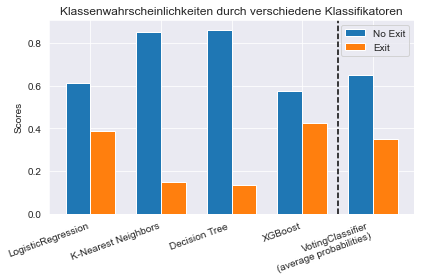

In [106]:

clf1 = best_lr_clf.best_estimator_
clf2 = best_svc_clf.best_estimator_
clf3 = tree_clf.best_estimator_
clf4 = best_xgb_clf.best_estimator_


eclf = VotingClassifier(
    estimators=[('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('tree', tree_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_)], voting="soft",weights=[1, 1, 1, 5],)



# predict class probabilities for all classifiers
probas = [c.fit(X_train, y_train).predict_proba(X_test) for c in (clf1, clf2,clf3 ,clf4,eclf)]

# get class probabilities for the first sample in the dataset

class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]



x = np.arange(5)  # the label locations
               
width = 0.35 # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class1_1, width, label='No Exit')
rects2 = ax.bar(x + width/2,class2_1, width, label='Exit')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Klassenwahrscheinlichkeiten durch verschiedene Klassifikatoren')

#ax.set_xticks(x,labels)
ax.legend()


#ax.bar_label(rects1, padding=2)
#ax.bar_label(rects2, padding=2)

# plot annotations
plt.axvline(3.5, color="k", linestyle="dashed")
#ax.set_xticks(ind + width)
ax.set_xticklabels(
    [   '',
        "LogisticRegression",
        "K-Nearest Neighbors",
        "Decision Tree ",
        "XGBoost",
        "VotingClassifier\n(average probabilities)"
    ],
    rotation=20,
    ha="right",
)


fig.tight_layout()

plt.show()

(array([0.        , 0.04091653, 1.        ]),
 array([0.        , 0.86764706, 1.        ]),
 array([2, 1, 0], dtype=int64),
 0.9133652642726486)

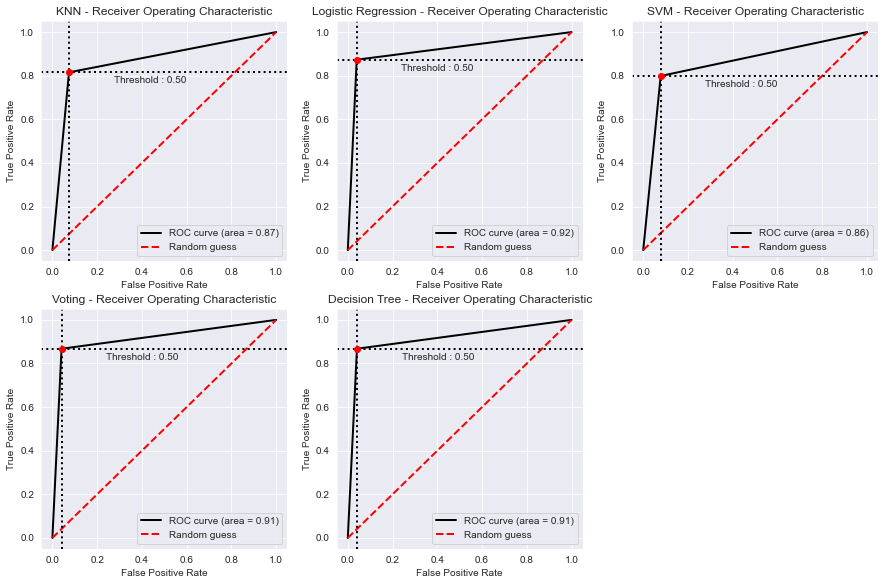

In [107]:
ax = plt.figure(figsize=(15,15))
ax.add_subplot(3,3,1)
bc1.plot_roc_curve( title='KNN - Receiver Operating Characteristic')
ax.add_subplot(3,3,2)
bc2.plot_roc_curve( title='Logistic Regression - Receiver Operating Characteristic')
ax.add_subplot(3,3,3)
bc3.plot_roc_curve( title='SVM - Receiver Operating Characteristic')
ax.add_subplot(3,3,4)
bc4.plot_roc_curve( title='Voting - Receiver Operating Characteristic')
ax.add_subplot(3,3,5)
bc5.plot_roc_curve( title='Decision Tree - Receiver Operating Characteristic')
#ax.add_subplot(3,3,6)